# **LSTM-Based Time Series Prediction for Fuel Consumption in Guatemala** 📊

Lorem ipsum dolor sit amet, consectetur adipiscing elit. Etiam ultrices, dui id viverra ornare, massa leo egestas ipsum, quis tempus sapien lorem sed odio. In non tempor magna. Vestibulum purus magna, pellentesque quis mattis a, interdum eu turpis. Proin vestibulum imperdiet eros non luctus. Sed gravida magna finibus interdum pulvinar. Nam euismod justo id elit condimentum commodo. Curabitur tempus suscipit turpis a finibus. In interdum enim efficitur, venenatis metus cursus, elementum ipsum. Praesent ut lacinia orci, et egestas neque. Maecenas pretium dapibus tellus id imperdiet. Curabitur convallis aliquam vulputate. Suspendisse ultrices pharetra tincidunt. Fusce nisl lacus, faucibus vel elementum at, pellentesque sed nisl. Lorem ipsum dolor sit amet, consectetur adipiscing elit. Suspendisse non justo nec urna pretium consequat sed ac sapien.

**Authors:**
- [Andrea Ramírez](https://github.com/Andrea-gt)
- [Adrian Flores](https://github.com/adrianRFlores)

***

## **Import Libraries** ⬇️

In [1]:
!pip install keras-tuner

In [2]:
# Data manipulation and visualization
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from tensorflow import keras
import keras_tuner as kt
from operator import concat

# Standard libraries
import warnings
warnings.filterwarnings('ignore')

# ===== ===== Reproducibility Seed ===== =====
# Set a fixed seed for the random number generator for reproducibility
random_state = 42

# Set matplotlib inline
%matplotlib inline

# Set default figure size
plt.rcParams['figure.figsize'] = (6, 4)

# Define custom color palette
palette = sns.color_palette("viridis", 12)

# Set the style of seaborn
sns.set(style="whitegrid")

# Set TensorFlow Global Seed
tf.random.set_seed(random_state)

## **Data Upload** 📄

In [3]:
def read_and_process_excel(file_names):
    dfs = []  # Initialize an empty list to store DataFrames

    for file_name in file_names:
        # Read the Excel file while skipping the first six rows of headers
        df = pd.read_excel(file_name, skiprows=6)

        # Drop the last three rows from the DataFrame to remove any unwanted data
        df = df.iloc[:-3]

        # Convert the 'Fecha' column to datetime format
        df['Fecha'] = pd.to_datetime(df['Fecha'])

        # Set the 'Fecha' column as the index of the DataFrame
        df.set_index('Fecha', inplace=True)

        # Select only the specified columns and create a new column 'Diesel' by combining 'Diesel alto azufre' and 'Diesel bajo azufre'
        df['Diesel'] = df['Diesel alto azufre'].fillna(0) + df['Diesel bajo azufre'].fillna(0)

        # Select only the relevant columns: Gasolina regular, Gasolina superior, Gas licuado de petróleo, and the new Diesel column
        df = df[['Gasolina regular', 'Gasolina superior', 'Gas licuado de petróleo', 'Diesel']]

        # Append the processed DataFrame to the list
        dfs.append(df)

    return dfs  # Return the list of DataFrames

In [4]:
# List of Excel file names to be processed
file_names = ["consumo.xlsx", "importacion.xlsx"]
dataset_names = ["Consumo", "Importacion", "Precios"]

# Call the function to read and process the Excel files, storing the result in the dataframes variable
dataframes = read_and_process_excel(file_names)

In [5]:
def read_price_df(sheetname, skip):
  # Read the Excel file while skipping the first six rows of headers
  df = pd.read_excel("precios.xlsx", skiprows=skip, sheet_name=sheetname)
  # Drop the last three rows from the DataFrame to remove any unwanted data
  df = df.iloc[1:-3]
  # Convert the 'Fecha' column to datetime format
  df['Fecha'] = pd.to_datetime(df['FECHA'])
  # Set the 'Fecha' column as the index of the DataFrame
  df.set_index('Fecha', inplace=True)
  # Remove last column
  df = df.iloc[:, :-1]
  # Rename the columns correctly
  df.rename(columns={
      'FECHA': 'Fecha',
      'Tipo de Cambio': 'Tipo de Cambio',
      'Superior': 'Gasolina superior',
      'Regular': 'Gasolina regular',
      'Diesel': 'Diesel',
      'Bunker': 'Bunker',
      'Glp Cilindro 25Lbs.': 'Gas licuado de petróleo'
  }, inplace=True)
  # Select only the relevant columns: Gasolina regular, Gasolina superior, Gas licuado de petróleo, and Diesel
  df = df[['Gasolina regular', 'Gasolina superior', 'Gas licuado de petróleo', 'Diesel']]
  # Drop NaN values from the final DataFrame
  df.dropna(inplace=True)
  return df

In [6]:
list_price_params = [("2021", 6), ("2022", 6), ("2023", 7), ("2024", 7)]

# Initialize an empty list to hold DataFrames
df_list = []

# Loop through each parameter to read and append DataFrames to the list
for year, skip in list_price_params:
    df = read_price_df(year, skip)
    df_list.append(df)

# Concatenate all DataFrames in the list into a single DataFrame
df = pd.concat(df_list)
# Optionally, sort the index if necessary
df.sort_index(inplace=True)
# Display the final DataFrame
dataframes.append(df)

## **Exploratory Analysis** 🔎

### **(1) Exploración y Limpieza Inicial de los Datos**

Para facilitar la comprensión y el manejo del conjunto de datos, se procederá a modificar los nombres de las variables. Este cambio permitirá una organización más clara y una interpretación más precisa de la información.

In [7]:
# Dictionary to rename columns for better readability
rename_col = {
    'Gasolina regular': 'gasoline_regular',    # Renaming 'Gasolina regular' to 'gasoline_regular'
    'Gasolina superior': 'gasoline_superior',  # Renaming 'Gasolina superior' to 'gasoline_superior'
    'Gas licuado de petróleo': 'liquefied_gas', # Renaming 'Gas licuado de petróleo' to 'liquefied_gas'
    'Diesel': 'diesel'                        # Renaming 'Diesel' to 'diesel'
}

In [8]:
for i, df in enumerate(dataframes):
  # Use a pandas function to rename the current function
  df = df.rename(columns = rename_col)
  # Change the index name from 'Fecha' to 'date'
  df.rename_axis('date', inplace=True)
  # Ensure all columns are numeric
  df = df.astype('float64')
  # Save changes
  dataframes[i] = df
  print(df.head(2), "\n")

            gasoline_regular  gasoline_superior  liquefied_gas     diesel
date                                                                     
2000-01-01         202645.20          308156.82  194410.476190  634667.06
2000-02-01         205530.96          307766.31  174710.552381  642380.66 

            gasoline_regular  gasoline_superior  liquefied_gas     diesel
date                                                                     
2001-01-01         177776.50          373963.96  194065.738095  566101.99
2001-02-01         123115.99          243091.07  170703.380952  489525.80 

            gasoline_regular  gasoline_superior  liquefied_gas  diesel
date                                                                  
2021-01-01             21.11              21.91           99.0   17.61
2021-01-02             21.11              21.91           99.0   17.61 



## **Time Series Forecasting 📅**

### **(1) Elección de Series de Tiempo a Utilizar**

> - **Consumo de Diésel**: Para analizar las tendencias y patrones en el uso de diésel a lo largo de los años, dadas las fuertes fluctuaciones observadas.
> - **Importación de Gasolina Regular**: Para obtener información sobre el aparente aumento en la importación de la gasolina regular.
> - **Precio de Diesel**: Para analizar las tendencias en el precio de los combustibles a lo largo de los años, dadas sus fluctuaciones significativas.

In [9]:
diesel_consumption = dataframes[0].diesel
regular_importation = dataframes[1].gasoline_regular
diesel_price = dataframes[2].diesel

### **(2) Información General de las Series de Tiempo**

In [10]:
def get_information(df):
    # Find the start of the time series
    start_date = df.index.min()
    # Find the end of the time series
    end_date = df.index.max()
    # Find the frequency of the time series
    frequency = pd.infer_freq(df.index)

    # Print the results nicely
    print("Time Series Analysis:")
    print("---------------------")
    print(f"Start Date: {start_date.date()}")
    print(f"End Date: {end_date.date()}")
    print(f"Frequency: {frequency}")

#### **(1) Consumo de Diésel**

In [11]:
get_information(diesel_consumption)

Time Series Analysis:
---------------------
Start Date: 2000-01-01
End Date: 2024-05-01
Frequency: MS


**Observaciones 💡 -->**

> - **Fecha de inicio**: 2000-01-01. Indica que la serie de tiempo comienza el 1 de enero de 2000.
> - **Fecha de finalización**: 2024-05-01. Indica que la serie de tiempo se extiende hasta el 1 de mayo de 2024.
> - **Frecuencia**: MS (Inicio del mes). Significa que los datos se registran al inicio de cada mes.

<Axes: xlabel='date'>

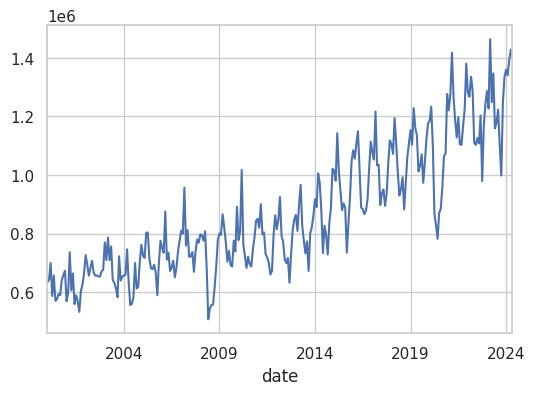

In [12]:
diesel_consumption.plot()

#### **(2) Importación de Gasolina Regular**

In [13]:
get_information(regular_importation)

Time Series Analysis:
---------------------
Start Date: 2001-01-01
End Date: 2024-05-01
Frequency: MS


**Observaciones 💡 -->**

> - **Fecha de inicio**: 2001-01-01. Indica que la serie de tiempo comienza el 1 de enero de 2001.
> - **Fecha de finalización**: 2024-05-01. Indica que la serie de tiempo se extiende hasta el 1 de mayo de 2024.
> - **Frecuencia**: MS (Inicio del mes). Significa que los datos se registran al inicio de cada mes.

<Axes: xlabel='date'>

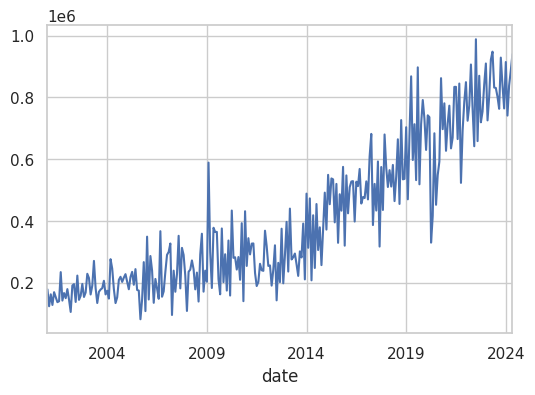

In [14]:
regular_importation.plot()

#### **(3) Precio del Diesel**

In [15]:
get_information(diesel_price)

Time Series Analysis:
---------------------
Start Date: 2021-01-01
End Date: 2024-07-28
Frequency: None


**Observaciones 💡 -->**

> - **Fecha de inicio**: 2021-01-01. Indica que la serie de tiempo comienza el 1 de enero de 2021.
> - **Fecha de finalización**: 2024-07-28. Indica que la serie de tiempo se extiende hasta el 28 de julio de 2024.
> - **Frecuencia**: Ninguna. Significa que no es posible inferir de manera automática la frecuencia de los datos. A pesar de esto, se sabe que se tiene una entrada por día hasta la última fecha registrada.

<Axes: xlabel='date'>

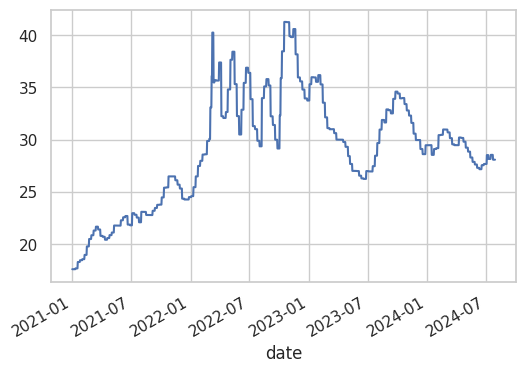

In [16]:
diesel_price.plot()

### **(3) ADF y Transformaciones**

In [17]:
def adf_test(series):
    result = adfuller(series)
    adf_statistic = result[0]
    p_value = result[1]
    critical_values = result[4]

    print('ADF Statistic:', adf_statistic)
    print('p-value:', p_value)
    print('Critical Values:')
    for key, value in critical_values.items():
        print(f'  {key}: {value:.3f}')

    if p_value < 0.05:
        print("The series is stationary (reject H0).")
        return True

    else:
        print("The series is non-stationary (fail to reject H0).")
        return False

In [18]:
def find_stationarity(series):
    diff_series = series.copy()
    differencing_order = 0

    while not adf_test(diff_series):
        differencing_order += 1
        diff_series = diff_series.diff().dropna()

    print(f"The series became stationary after {differencing_order} differencings.\n")
    return diff_series

In [19]:
diesel_consumption_diff = find_stationarity(diesel_consumption)
regular_importation_diff = find_stationarity(regular_importation)
diesel_price_diff = find_stationarity(diesel_price)

ADF Statistic: 0.145239821178108
p-value: 0.9690175028779469
Critical Values:
  1%: -3.454
  5%: -2.872
  10%: -2.572
The series is non-stationary (fail to reject H0).
ADF Statistic: -7.094677414843632
p-value: 4.3199961290916e-10
Critical Values:
  1%: -3.454
  5%: -2.872
  10%: -2.572
The series is stationary (reject H0).
The series became stationary after 1 differencings.

ADF Statistic: 0.8288289928204887
p-value: 0.992087554110633
Critical Values:
  1%: -3.455
  5%: -2.872
  10%: -2.572
The series is non-stationary (fail to reject H0).
ADF Statistic: -10.111097641346007
p-value: 9.998584727414137e-18
Critical Values:
  1%: -3.455
  5%: -2.872
  10%: -2.572
The series is stationary (reject H0).
The series became stationary after 1 differencings.

ADF Statistic: -2.377813354587725
p-value: 0.14809658351111532
Critical Values:
  1%: -3.435
  5%: -2.864
  10%: -2.568
The series is non-stationary (fail to reject H0).
ADF Statistic: -7.090525705456006
p-value: 4.4224777713128013e-10
Cri

### **(4) LSTM Models**

#### **(1) Normalización de Datos**

In [20]:
# Create an instance of StandardScaler for scaling time series data
scaler = StandardScaler()

def scale_time_series(series):
    # Reshape the series to 2D
    series_reshaped = series.values.reshape(-1, 1)
    scaled_values = scaler.fit_transform(series_reshaped)
    print(scaled_values[1:5], "\n")
    return scaled_values

In [21]:
diesel_consumption_scaled = scale_time_series(diesel_consumption_diff)
regular_importation_scaled = scale_time_series(regular_importation_diff)
diesel_price_scaled = scale_time_series(diesel_price_diff)

[[ 0.6596291 ]
 [-1.39176556]
 [ 0.81270602]
 [-1.0670791 ]] 

[[ 0.26658337]
 [-0.27563983]
 [ 0.28724053]
 [-0.13780327]] 

[[-0.01703256]
 [-0.01703256]
 [-0.01703256]
 [-0.01703256]] 



#### **(2) División de Datos: Entrenamiento, Validación y Prueba**

In [22]:
def train_val_test_split(data_array, train_size=0.7, val_size=0.15, test_size=0.15):
    # Calculate the number of entries in the dataset
    n = len(data_array)

    # Ensure that the sizes sum to 1
    assert np.isclose(train_size + val_size + test_size, 1.0), "Sizes must sum to 1."

    # Calculate the indices for the splits
    train_end = int(train_size * n)  # End index for the training set
    val_end = train_end + int(val_size * n)  # End index for the validation set

    # Split the dataset into train, validation, and test sets
    train_array = data_array[:train_end]
    val_array = data_array[train_end:val_end]
    test_array = data_array[val_end:]

    return train_array, val_array, test_array

In [23]:
# Diesel Consumption Data
train_consumption, val_consumption, test_consumption = train_val_test_split(diesel_consumption_scaled)
# Regular Fuel Importation Data
train_regular, val_regular, test_regular = train_val_test_split(regular_importation_scaled)
# Diesel Price Data
train_price, val_price, test_price = train_val_test_split(diesel_price_scaled)

#### **(3) Transformaciones a los Conjuntos de Datos**

In [24]:
def supervised_series(series, lags=1):
    # Initialize lists to hold input and output sequences
    input_series = []
    output_series = []
    # Loop through the series to create input-output pairs
    for i in range(len(series) - lags):
        # Collect the input sequence (previous 'lags' observations)
        input_value = series[i:(i + lags), 0]
        # Collect the output value (next observation)
        output_value = series[i + lags, 0]
        # Append to the respective lists
        input_series.append(input_value)
        output_series.append(output_value)
    return np.array(input_series), np.array(output_series)

In [25]:
# Diesel Consumption Data
x_train_consumption, y_train_consumption = supervised_series(train_consumption)
x_val_consumption, y_val_consumption = supervised_series(val_consumption)
x_test_consumption, y_test_consumption = supervised_series(test_consumption)

# Regular Fuel Importation Data
x_train_regular, y_train_regular = supervised_series(train_regular)
x_val_regular, y_val_regular = supervised_series(val_regular)
x_test_regular, y_test_regular = supervised_series(test_regular)

# Diesel Price Data
x_train_price, y_train_price = supervised_series(train_price)
x_val_price, y_val_price = supervised_series(val_price)
x_test_price, y_test_price = supervised_series(test_price)

In [26]:
# Diesel Consumption Data
x_train_consumption = np.reshape(x_train_consumption,(x_train_consumption.shape[0],1,1))
x_val_consumption = np.reshape(x_val_consumption,(x_val_consumption.shape[0],1,1))
x_test_consumption = np.reshape(x_test_consumption,(x_test_consumption.shape[0],1,1))

# Regular Fuel Importation Data
x_train_regular = np.reshape(x_train_regular,(x_train_regular.shape[0],1,1))
x_val_regular = np.reshape(x_val_regular,(x_val_regular.shape[0],1,1))
x_test_regular = np.reshape(x_test_regular,(x_test_regular.shape[0],1,1))

# Diesel Price Data
x_train_price = np.reshape(x_train_price,(x_train_price.shape[0],1,1))
x_val_price = np.reshape(x_val_price,(x_val_price.shape[0],1,1))
x_test_price = np.reshape(x_test_price,(x_test_price.shape[0],1,1))

In [27]:
consumption_dataset = {
    "x_train": x_train_consumption,
    "y_train": y_train_consumption,
    "x_val": x_val_consumption,
    "y_val": y_val_consumption,
    "x_test": x_test_consumption,
    "y_test": y_test_consumption
}

importation_dataset = {
    "x_train": x_train_regular,
    "y_train": y_train_regular,
    "x_val": x_val_regular,
    "y_val": y_val_regular,
    "x_test": x_test_regular,
    "y_test": y_test_regular
}

price_dataset = {
    "x_train": x_train_price,
    "y_train": y_train_price,
    "x_val": x_val_price,
    "y_val": y_val_price,
    "x_test": x_test_price,
    "y_test": y_test_price
}

#### **(4) Creación de Modelos LSTM**

Para las primeras iteraciones de cada serie, se crearán modelos con dos atributos distintos: cantidad de unidades en la capa LSTM y optimizador. En esta iteración, la elección de estos atributos es arbitraria y se detalla a continuación:

*   **Primer Modelo**:
    * Unidades LSTM: 1
    * Optimizador: Adam (LR = 0.001)

*   **Segundo Modelo**:
    * Unidades LSTM: 5
    * Optimizador: SGD (LR = 0.001)



In [28]:
def init_model(param_dict, name=None):
  inputs = keras.layers.Input((param_dict["step"], param_dict["features"]))
  lstm_out = keras.layers.LSTM(param_dict["units"])(inputs)
  outputs = keras.layers.Dense(1)(lstm_out)

  model = keras.Model(inputs=inputs, outputs=outputs)
  if name:
    model.name = name
  model.summary()

  model.compile(loss='mean_squared_error', optimizer=param_dict["optimizer"])

  return model

In [29]:
def fit_model(model, dataset_dict, epochs, batch):
  history = model.fit(
      x = dataset_dict["x_train"],
      y = dataset_dict["y_train"],
      batch_size = batch,
      epochs = epochs,
      shuffle = False,
      validation_data = (dataset_dict["x_val"], dataset_dict["y_val"]),
      verbose=0
  )

  print("Training Loss")
  model.evaluate(
      x = dataset_dict["x_train"],
      y = dataset_dict["y_train"]
  )
  print("\nValidation Loss")
  model.evaluate(
      x = dataset_dict["x_val"],
      y = dataset_dict["y_val"]
  )
  print("\nTesting Loss")
  model.evaluate(
      x = dataset_dict["x_test"],
      y = dataset_dict["y_test"]
  )

  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('Model Loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Validation'], loc='center')

In [30]:
first_params = {
    "batch": 1,
    "units": 1,
    "step": 1,
    "features": 1,
    "optimizer": "adam",
}

second_params = {
    "batch": 1,
    "units": 5,
    "step": 1,
    "features": 1,
    "optimizer": "sgd",
}

##### **(1) Primer Modelo**

In [31]:
consumption_model = init_model(first_params, "consumption_model")
regular_model = init_model(first_params, "importation_model")
price_model = init_model(first_params, "price_model")

Model: "consumption_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 1, 1)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 1)                   │              12 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │               2 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14 (56.00 B)

 Trainable params: 14 (56.00 B)

 Non-trainable params: 0 (0.00 B)

Model: "importation_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 1, 1)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 1)                   │              12 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │               2 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14 (56.00 B)

 Trainable params: 14 (56.00 B)

 Non-trainable params: 0 (0.00 B)

Model: "price_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 1, 1)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 1)                   │              12 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │               2 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14 (56.00 B)

 Trainable params: 14 (56.00 B)

 Non-trainable params: 0 (0.00 B)

Training Loss
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6167  

Validation Loss
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.0544 

Testing Loss
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.6887 


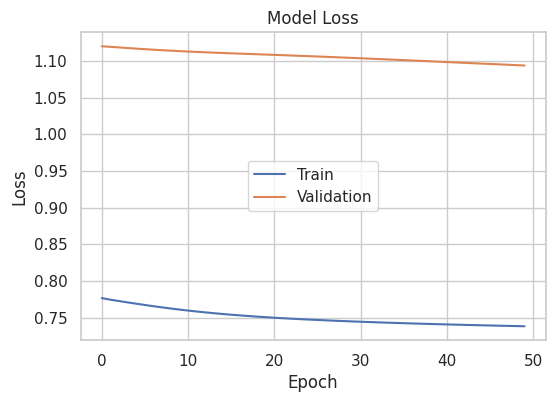

In [32]:
fit_model(consumption_model, consumption_dataset, 50, first_params["batch"])

Training Loss
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3571  

Validation Loss
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.2223

Testing Loss
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.9013 


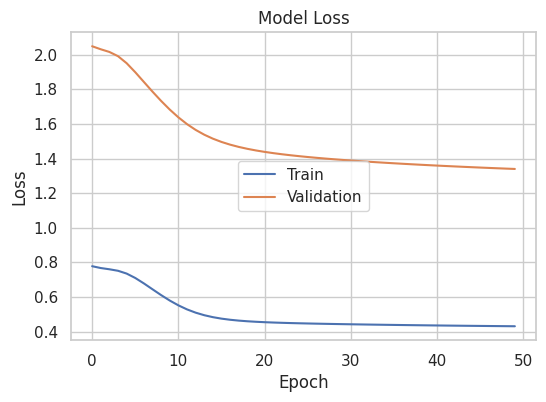

In [33]:
fit_model(regular_model, importation_dataset, 50, first_params["batch"])

Training Loss
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.8244  

Validation Loss
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3722 

Testing Loss
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1663 


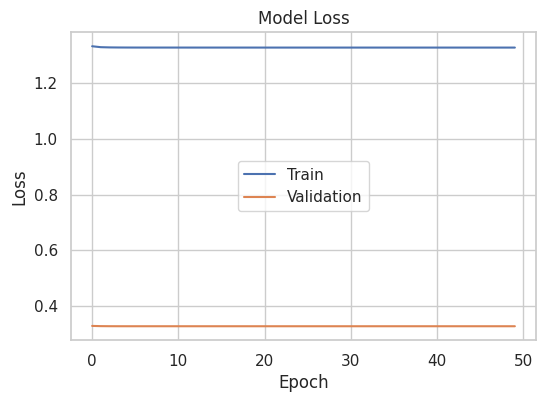

In [34]:
fit_model(price_model, price_dataset, 50, first_params["batch"])

**Observaciones 💡 -->**

> - Los modelos de importación y consumo no muestran señales de sobreajuste, ya que sus curvas de entrenamiento y validación no convergen en ningún momento.
- El modelo de precios presenta una pérdida casi constante a lo largo de todas las épocas, con una menor pérdida en validación que en entrenamiento. Este comportamiento podría deberse a una mala configuración de los parámetros del modelo o a problemas con las transformaciones de datos previas.
- El modelo de importación tiene la curva de pérdida más definida y, al mismo tiempo, la pérdida más alta entre todos los modelos. Por otro lado, el modelo de consumo no muestra una reducción significativa en la pérdida, y la pérdida del modelo de precios permanece constante durante las 50 épocas.
- Es probable que no se necesiten más épocas en iteraciones futuras, ya que los modelos convergen a un valor de pérdida antes de alcanzar las 50 épocas.

##### **(2) Segundo Modelo**

In [35]:
consumption_model = init_model(second_params, "consumption_model_2")
regular_model = init_model(second_params, "importation_model_2")
price_model = init_model(second_params, "price_model_2")

Model: "consumption_model_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, 1, 1)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 1)                   │              12 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │               2 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14 (56.00 B)

 Trainable params: 14 (56.00 B)

 Non-trainable params: 0 (0.00 B)

Model: "importation_model_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)           │ (None, 1, 1)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_4 (LSTM)                        │ (None, 1)                   │              12 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1)                   │               2 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14 (56.00 B)

 Trainable params: 14 (56.00 B)

 Non-trainable params: 0 (0.00 B)

Model: "price_model_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)           │ (None, 1, 1)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_5 (LSTM)                        │ (None, 1)                   │              12 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │               2 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14 (56.00 B)

 Trainable params: 14 (56.00 B)

 Non-trainable params: 0 (0.00 B)

Training Loss
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6282 

Validation Loss
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.0587 

Testing Loss
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.6907 


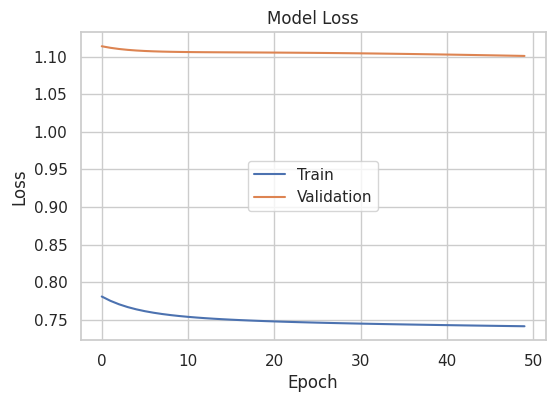

In [36]:
fit_model(consumption_model, consumption_dataset, 50, second_params["batch"])

Training Loss
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3907 

Validation Loss
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.4626 

Testing Loss
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.9515 


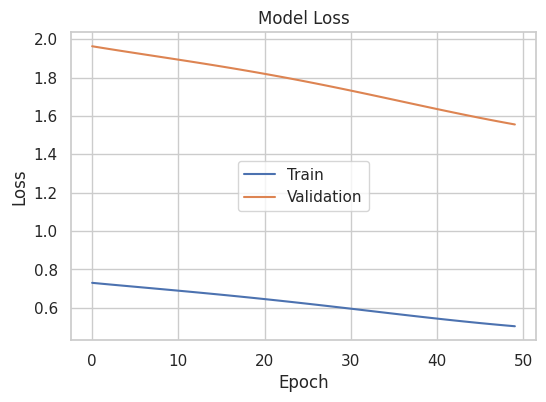

In [37]:
fit_model(regular_model, importation_dataset, 50, second_params["batch"])

Training Loss
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.8268 

Validation Loss
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3765 

Testing Loss
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1670 


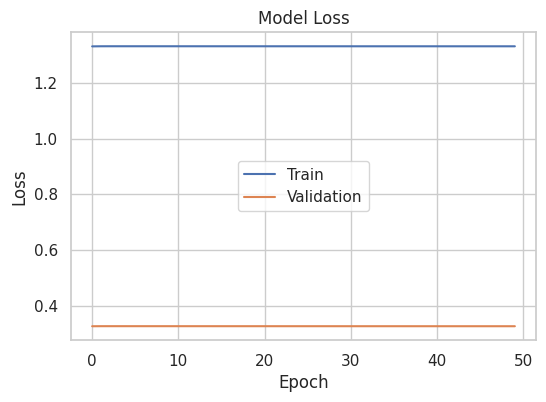

In [38]:
fit_model(price_model, price_dataset, 50, second_params["batch"])

**Observaciones 💡 -->**

> - Al cambiar el optimizador y la cantidad de unidades en la capa LSTM, se observa un comportamiento ligeramente distinto en las gráficas de pérdida de los modelos. El modelo de precios mostró el mismo comportamiento que en su versión anterior, mientras que los modelos de consumo e importación presentan curvas menos pronunciadas.
- El modelo de consumo mostró un comportamiento casi constante, con una diferencia de aproximadamente 0.05 entre la pérdida de la primera época y la última.
- El modelo de importación sigue registrando los valores de pérdida más altos, manteniendo la pérdida más elevada entre todos los modelos. En este caso, la curva de pérdida presenta un comportamiento casi lineal decreciente.
- Es difícil atribuir los cambios observados a un factor específico, por lo que se determinarán los mejores parámetros para futuros modelos con el fin de evaluar su impacto en la serie de tiempo.

##### **(3) Tuneo de Hiperparámetros**

En esta sección, se emplearán las utilidades del paquete `keras_tuner` para realizar una búsqueda de los mejores parámetros dentro de un rango de opciones para cada modelo de las series de tiempo. Se utilizará el proceso de `GridSearch` con el objetivo de minimizar la pérdida en el conjunto de validación para cada serie. En este caso, la búsqueda se realizará sobre los parámetros:


*   **Step**: [1, 5]
*   **Units** (Unidades en la capa LSTM): [1, 64], aumentando 4 unidades en cada iteración.
*   **Activation:** (LSTM): ['sigmoid', 'relu', 'tanh']
*   **Optimizer:** ['adam' (Adaptivo), 'sgd' (Descenso gradiente)]



In [39]:
# Define the model building function
def build_model(hp):
    step = hp.Int('step', min_value=1, max_value=5, step=1)
    features = 1
    units = hp.Int('units', min_value=1, max_value=64, step=4)

    inputs = keras.layers.Input((step, features))
    lstm_out = keras.layers.LSTM(units=units, activation=hp.Choice('activation', values=['sigmoid', 'relu', 'tanh']))(inputs)
    outputs = keras.layers.Dense(units=1)(lstm_out)

    model = keras.Model(inputs=inputs, outputs=outputs)

    model.compile(
        loss='mean_squared_error',
        optimizer=hp.Choice('optimizer', values=['adam', 'sgd'])
    )

    return model

In [40]:
# Initialize the tuner
tuner = kt.GridSearch(
    build_model,
    objective='val_loss',
    max_trials=10,
    executions_per_trial=3,
    directory='tuner_outputs',
    project_name='fuel_gt_analysis'
)

# Print a summary of the search space
tuner.search_space_summary()

Reloading Tuner from tuner_outputs/fuel_gt_analysis/tuner0.json
Search space summary
Default search space size: 4
step (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 5, 'step': 1, 'sampling': 'linear'}
units (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 64, 'step': 4, 'sampling': 'linear'}
activation (Choice)
{'default': 'sigmoid', 'conditions': [], 'values': ['sigmoid', 'relu', 'tanh'], 'ordered': False}
optimizer (Choice)
{'default': 'adam', 'conditions': [], 'values': ['adam', 'sgd'], 'ordered': False}


In [41]:
def tune_and_fit_model(dataset_dict, epochs):
  # Start the search
  tuner.search(
      x=dataset_dict["x_train"],
      y=dataset_dict["y_train"],
      epochs=epochs,
      validation_data=(dataset_dict["x_val"], dataset_dict["y_val"]),
      callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)]
  )

  # Get the optimal hyperparameters
  best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

  # Build the model with the optimal hyperparameters and train it
  model = tuner.hypermodel.build(best_hps)
  history = model.fit(
      x=dataset_dict["x_train"],
      y=dataset_dict["y_train"],
      epochs=epochs,
      validation_data=(dataset_dict["x_val"], dataset_dict["y_val"]),
      batch_size=1,
      verbose=0
  )

  # Print the best hyperparameters
  print(f"""
  The optimal number of units in the LSTM layer is {best_hps.get('units')},
  the optimal number of steps is {best_hps.get('step')},
  the optimal LSTM activation function is {best_hps.get('activation')},
  the optimal optimizer is {best_hps.get('optimizer')}.
  """)

  print("Training Loss")
  model.evaluate(
      x = dataset_dict["x_train"],
      y = dataset_dict["y_train"]
  )
  print("\nValidation Loss")
  model.evaluate(
      x = dataset_dict["x_val"],
      y = dataset_dict["y_val"]
  )
  print("\nTesting Loss")
  model.evaluate(
      x = dataset_dict["x_test"],
      y = dataset_dict["y_test"]
  )

  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('Model Loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Validation'], loc='center')


  The optimal number of units in the LSTM layer is 5,
  the optimal number of steps is 1,
  the optimal LSTM activation function is relu,
  the optimal optimizer is adam.
  
Training Loss
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5928  

Validation Loss
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.0376 

Testing Loss
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.7774 


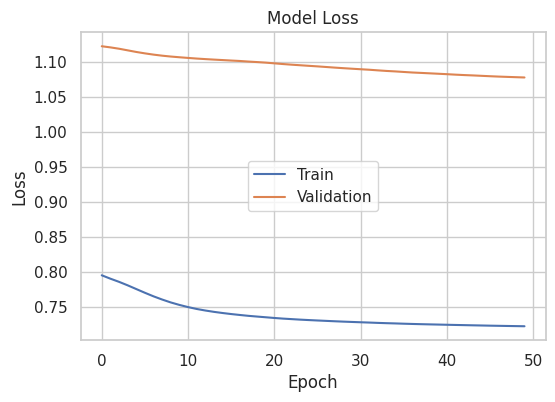

In [42]:
tune_and_fit_model(consumption_dataset, 50)


  The optimal number of units in the LSTM layer is 5,
  the optimal number of steps is 1,
  the optimal LSTM activation function is relu,
  the optimal optimizer is adam.
  
Training Loss
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3358  

Validation Loss
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.1805 

Testing Loss
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.8218 


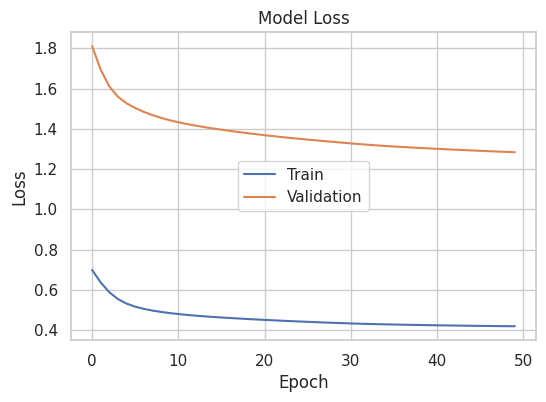

In [43]:
tune_and_fit_model(importation_dataset, 50)


  The optimal number of units in the LSTM layer is 5,
  the optimal number of steps is 1,
  the optimal LSTM activation function is relu,
  the optimal optimizer is adam.
  
Training Loss
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.8239  

Validation Loss
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3714 

Testing Loss
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1662 


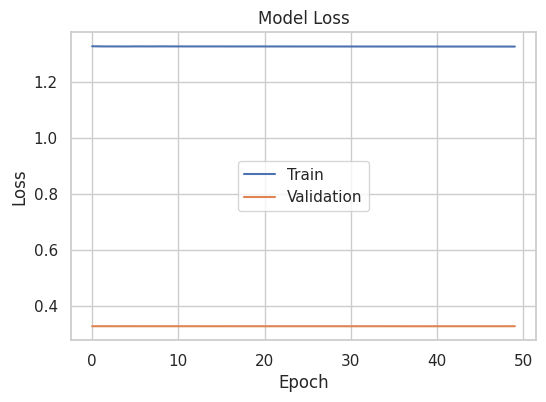

In [44]:
tune_and_fit_model(price_dataset, 50)

**Observaciones 💡 -->**

> - A pesar de obtener valores de pérdida más bajos para todas las series de tiempo, la diferencia entre los modelos con parámetros optimizados y los modelos con parámetros arbitrarios no es significativa.
- El comportamiento de la serie de precios es idéntica a las anteriores, potencialmente exhibiendo alguna deficiencia en la preparación del conjunto de datos o mal ajuste del modelo para esta serie de tiempo.
- Las curvas de pérdida para la serie de consumo e importación es más pronunciada, acercándose más a un comportamiento deseado en el cambio de pérdida a través del tiempo.
- No hay necesidad de agregar más épocas al entrenamiento de los modelos ya que todos los modelos convergen aproximadamente a un valor final.